In [2]:
%matplotlib inline
%load_ext line_profiler
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import numpy as np
from os.path import join
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
import colorcet as cc
from ipdb import set_trace
import pandas as pd
from p_tqdm import p_map, p_umap # parallel map
from tqdm.auto import tqdm, trange
from functools import partial
pmap = p_map
lmap = lambda f, L: list(map(f, L))

import PIL
from io import BytesIO
import PIL.Image
from tqdm.auto import tqdm
import umap
from sklearn.manifold import TSNE


from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from cifarclass import cifar100_classes

from pncommon import * # my stuff

rng = np.random.default_rng(2)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Load Raw Data

In [ ]:
name = "CIFAR100_test"
train_set = "CIFAR100_train"

label_mapping=cifar100_classes
classes = list(label_mapping.values())
NUM_SAMPLES = 10000
NUM_LABELS=100

print("loading data")

all_group_paths = ['../processed/cifar100/clip_new/group2.pkl',
             '../processed/cifar100/resnets/group2.pkl']

all_groups = list(map(load_pickle, tqdm(all_group_paths)))
print("done")

print("loading dataset")
dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print("done")


## let's call grouped in 'pn-raw-form'
grouped = {k : g[name][k] for g in all_groups for k in g[name].keys()}
groups = list(grouped.keys())
print('groups: ', groups)

## add soft probs
def probs_to_softacc(probs):
    return np.array([probs[i, yi, :] for i, yi in enumerate(ytest)]).mean(0)

for _, G in grouped.items():
    G['xsoft'] = probs_to_softacc(G["probs"])
    
Graw = grouped # raw

## Load processed data (for convenient filtering/etc)

In [8]:
with open('./proc/jan1_proc.pk', 'rb') as file:
    Gproc = pickle.load(file)
print('groups:', Gproc.keys())

groups: dict_keys(['ClipViTB32', 'ClipViTB16', 'Resnet18-pretrained', 'Densenet121-pretrained', 'Resnet18', 'Densenet121'])


## Filter and plot

In [12]:
def accuracy(i, prof):
    true_label = ytest[i]
    return prof[true_label]

def nonmono(i, prof, sigma=1.0):
    acc = accuracy(i, prof)
    acc = gaussian_filter1d(acc, sigma=sigma) # smooth it
    #np.max(acc.reshape(-1, 1)- acc.reshape(1, -1))
    d = acc[1:] - acc[:-1] # first derivative
    nm = np.sum(np.abs(d.clip(max=0))) # itegrate only negative part
    return nm

# scores = np.array(lmap(lambda i: nonmono(i, Gproc[t][i]), trange(NUM_SAMPLES)))

In [57]:
from matplotlib.collections import LineCollection
def plot_colored_line(ax, x, y, zval, cmap, **params):
    """
        plot a line that changes color.
        colors: array of colors, one per pt.
    """
    # based on: https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html
    xy = np.array([x, y]).T # N x 2
    xy = xy.reshape(-1, 1, 2) # N x 1 x 2
    
    # segments: (numlines) x (points per line) x 2 (for x and y)
    segments = np.concatenate([xy[:-1], xy[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, **params)
    #  colors=colors
    lc.set_array(zval)
    line = ax.add_collection(lc)
    # ax.colorbar(line)
    return line

In [111]:
## random indices
N = 500
INDICES = np.random.default_rng(2).choice(range(NUM_SAMPLES), N)

In [ ]:
## select indices based on filtering
mfilter = 'Resnet18'
# scores = np.array(lmap(lambda i: nonmono(i, Gproc[mfilter]['probs'][i]), trange(NUM_SAMPLES)))

idx = np.argsort(-scores)
INDICES = idx[:100]

sns.displot(scores, kind='hist')

accuracy type: freqs
common accuracy interval: (0.5980676093571623, 0.6627046465873718)


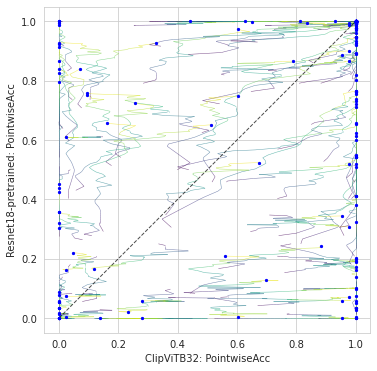

In [116]:
models = ['ClipViTB32', 'Resnet18-pretrained']
t = 'freqs' # probs or freqs

smooth = False
sigma = 1.0

## 
xkey = 'x' if t!='probs' else 'xsoft'
m1, m2 = models

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(6, 6))


x1,x2 = [Graw[m][xkey] for m in models]
xmin, xmax = max(x1.min(), x2.min()), min(x1.max(), x2.max()) # intersect intervals
print('accuracy type:', t)
print(f'common accuracy interval: ({xmin}, {xmax})')
    
xx = np.linspace(xmin, xmax, gridpts) # evenly spaced gridpts

for i in INDICES:
    y1,y2 = [accuracy(i, Graw[m][t][i]) for m in models] # extract raw profiles
    
    ys = []
    for x, y in zip((x1, x2), (y1, y2)):
        # linearly interpolate the curve on (common) uniform grid
        f = interp1d(x, y, kind='linear')
        yy = f(xx)
        if smooth:
            yy = gaussian_filter1d(yy, sigma=sigma)
        ys.append(yy)
    ys = np.array(ys)
    
    #line = ax.plot(ys[0,:], ys[1,:])
    line = plot_colored_line(ax, x=ys[0,:], y=ys[1,:], zval=xx, cmap='viridis', linewidth=0.5, zorder=2, alpha=0.7)
    plt.scatter(ys[0, -1], ys[1, -1], marker='o', s=5, c='blue', zorder=3)
    
z = np.linspace(0, 1, 10)
ax.plot(z, z, 'k--', alpha=0.7, linewidth=1);
ax.set_xlabel(f'{m1}: PointwiseAcc');
ax.set_ylabel(f'{m2}: PointwiseAcc');
ax.set_aspect('equal');

  0%|          | 0/10000 [00:00<?, ?it/s]

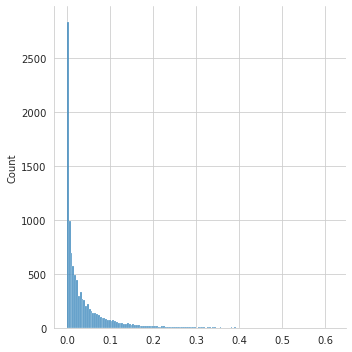

In [109]:
## select indices based on filtering
mfilter = 'Resnet18'
scores = np.array(lmap(lambda i: nonmono(i, Gproc[mfilter]['probs'][i]), trange(NUM_SAMPLES)))

idx = np.argsort(-scores)
INDICES = idx[:100]

sns.displot(scores, kind='hist')

In [97]:
idx = np.argsort(-scores)
INDICES = idx[:100]